In [103]:

import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Input , Lambda
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from collections import Counter
from math import comb



In [41]:
# from google.colab import files
# uploaded = files.upload()


In [121]:
#load resnet50
base_model = ResNet50(weights = 'imagenet' , include_top= False , pooling='avg')



In [148]:
def feature_Extraction(img_path):
  img = cv2.imread(img_path)

  if img is None:
    raise ValueError(f"Couldnot load image from the path {img_path}")

  img = cv2.resize(img , (224 , 224))
  img  = preprocess_input(img)
  img = np.expand_dims(img , axis = 0)                                         #output= (1, 224 , 224 , 3) , 1 is batch-size. images after using batch size (batch_size, height, width, channels) , just the img (224, 224, 3)
  features = base_model.predict(img)
  return features.flatten()

In [149]:
#build siamese model
def build_siamese_model_network():
  input_shape = (2048,)
  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  l1_layer = Lambda(lambda tensors : tf.abs(tensors[0] - tensors[1]))
  l1_distance = l1_layer([input_a , input_b])

  output = Dense(1 , activation='sigmoid')(l1_distance)
  model = Model(inputs = [input_a , input_b] , outputs = output)
  model.compile(loss = 'binary_crossentropy' , optimizer= 'adam' , metrics = ['accuracy'])
  return model

In [129]:
# 📁 Define your image paths and labels
images_path = [
    "/content/road1.png",
    "/content/road2.png",
    "/content/road3.jpg",
    "/content/road5.jpg",
    "/content/road6.jpg",
    "/content/tiger1.png",
    "/content/tiger2.png",
    "/content/leopard.jpg",
    "/content/deer.jpg",
    "/content/squarrel.jpg",
    "/content/road7.jpg",
     "/content/road8.jpg",
     "/content/dogs.jpg",
     "/content/cat.jpeg",
     "/content/Cat5.jpeg",
     "/content/Cat1.jpeg",
     "/content/mouse.png"

]

print("Number of unique pairs:", comb(len(images_path), 2))


Number of unique pairs: 136


In [130]:

# Label logic: same type = label 1, otherwise 0
images = {
    path: 1 if "road" in path else 2 for path in images_path
}


In [131]:
class_counts = Counter(images.values())
print("Class counts (label: count):", class_counts)


Class counts (label: count): Counter({2: 10, 1: 7})


In [150]:

# 🧩 Create image pairs and labels
x1, x2, y = [], [], []
for i in range(len(images_path)):
    for j in range(i + 1, len(images_path)):
        img1 = images_path[i]
        img2 = images_path[j]
        f1 = feature_Extraction(img1 )
        f2 = feature_Extraction(img2)
        label = 1 if images[img1] == images[img2] else 0
        x1.append(f1)
        x2.append(f2)
        y.append(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [151]:

# Convert to numpy arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

#  Train-Test Split
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(
    x1, x2, y, test_size=0.2, random_state=42
)

# Train the model
model = build_siamese_model_network()
history = model.fit([x1_train, x2_train], y_train, epochs=18, batch_size=8, validation_data=([x1_test, x2_test], y_test), verbose=1)

#  Evaluate on test data
y_pred = model.predict([x1_test, x2_test])
y_pred_labels = (y_pred > 0.4).astype(int)

Epoch 1/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5502 - loss: 0.9180 - val_accuracy: 0.5714 - val_loss: 0.7474
Epoch 2/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6440 - loss: 0.6178 - val_accuracy: 0.5357 - val_loss: 0.7306
Epoch 3/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8458 - loss: 0.4491 - val_accuracy: 0.6429 - val_loss: 0.6529
Epoch 4/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8668 - loss: 0.4566 - val_accuracy: 0.7857 - val_loss: 0.5950
Epoch 5/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8615 - loss: 0.3664 - val_accuracy: 0.7143 - val_loss: 0.5346
Epoch 6/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8863 - loss: 0.3014 - val_accuracy: 0.7143 - val_loss: 0.5054
Epoch 7/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9376 - loss: 0.2756 - val_accuracy: 0.8571 - val_loss: 0.4757
Epoch 8/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9677 - loss: 0.2152 - val_accuracy: 0.8214 - val_loss

In [152]:

acc = accuracy_score(y_test, y_pred_labels)
prec = precision_score(y_test, y_pred_labels)
rec = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)




# print("\n Evaluation on Test Set:")
print(f"Accuracy_score : {acc:.2f}")
print(f"Precision_score : {prec:.2f}")
print(f"Recall_score   : {rec:.2f}")
print(f"F1 Score_score : {f1:.2f}")



Accuracy_score : 0.89
Precision_score : 1.00
Recall_score   : 0.79
F1 Score_score : 0.88


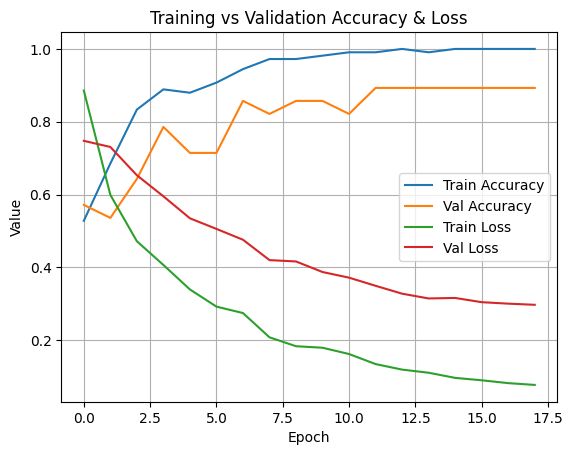

In [153]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training vs Validation Accuracy & Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

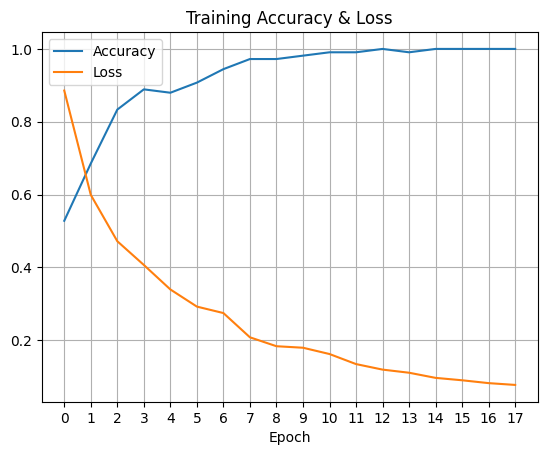

In [154]:

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['loss'], label="Loss")
plt.title("Training Accuracy & Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(len(history.history['accuracy'])))  # force integer labels
plt.show()

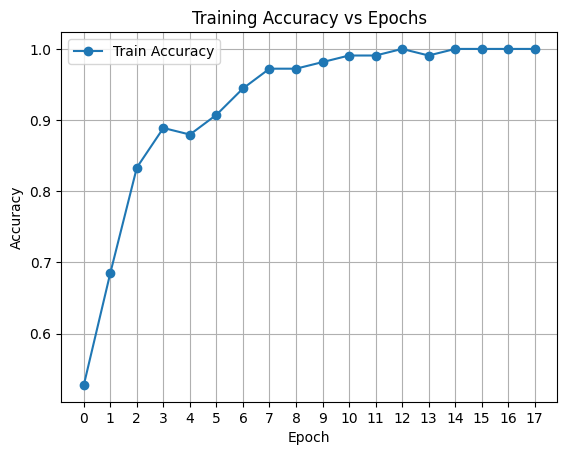

In [155]:
# 📊 Plot accuracy over epochs
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(ticks=range(len(history.history['accuracy'])))  # force integer labels
plt.legend()
plt.show()

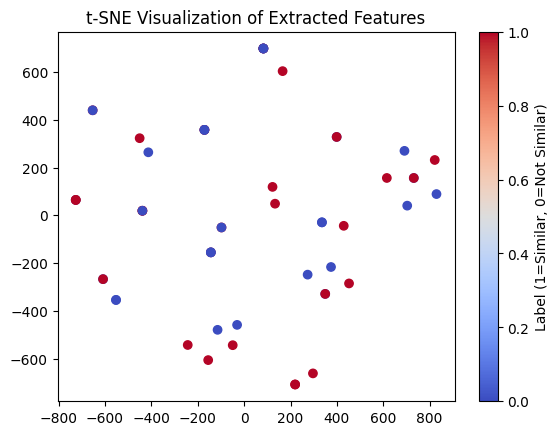

In [156]:

features = np.concatenate((x1_test, x2_test), axis=0)
labels = np.concatenate((y_test, y_test), axis=0)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
features_2d = tsne.fit_transform(features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm')
plt.title("t-SNE Visualization of Extracted Features")
plt.colorbar(label='Label (1=Similar, 0=Not Similar)')
plt.show()

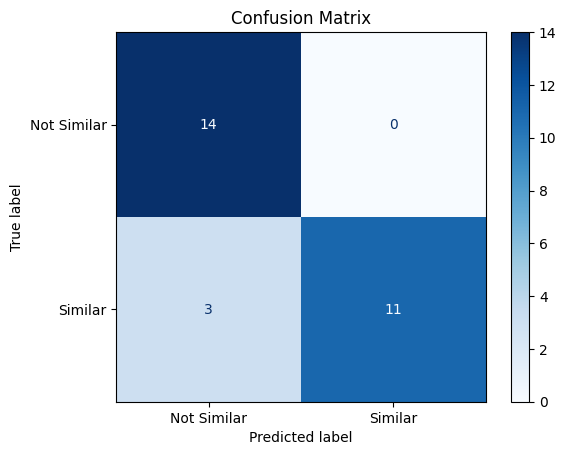

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()